# DEA Burn Cube animation <img align="right" src="dea_logo.jpg">

* [**Sign up to the DEA Sandbox**](https://docs.dea.ga.gov.au/setup/sandbox.html) to run this notebook interactively from a browser
* **Compatibility:** Notebook currently compatible with `DEA Dev Sandbox` environment
* **Products used:** 
[ga_ls8c_nbart_gm_fyear_3](https://explorer.dev.dea.ga.gov.au/products/ga_ls8c_nbart_gm_fyear_3),
[ga_s2_ard_bc_fyear_3](https://explorer.dev.dea.ga.gov.au/products/ga_s2_ard_bc_fyear_3)
* **Special requirements:** run in the notebook in DEA dev sandbox environment.
* **Prerequisites:** An _optional_ list of any notebooks that should be run or content that should be understood prior to launching this notebook

In [1]:
import itertools

import datacube
import dea_tools.datahandling
import dea_tools.bandindices
import geopandas as gpd
import matplotlib.pyplot as plt
import numpy as np
import xarray as xr
import datetime
import seaborn as sns
import matplotlib.dates as mdates
import pandas as pd
import os
import rasterio.features
from shapely.geometry import shape
from dea_tools.plotting import xr_animation
from tqdm import tqdm

from shapely.geometry import Polygon, MultiPolygon
import rioxarray
import json
from PIL import Image

from dea_tools.spatial import xr_rasterize

from IPython.core.display import Video, Image
# runtime is: https://app.sandbox.dea.ga.gov.au/

dc = datacube.Datacube(app='Burn Cube - Display Burn Cube by Animation notebook')

### Create Polygon by Kangaroo Island Latitude and Longitude

In [2]:
import pyproj

# KI ISLAND

lon =  137 
lat = -35.839

# convert to projected centre coordinates
transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3577")
easting,northing = transformer.transform(lat, lon)

In [3]:
#import pyproj

# Eastern VIC

#lon =  148
#lat = -37

# convert to projected centre coordinates
#transformer = pyproj.Transformer.from_crs("EPSG:4326", "EPSG:3577")
#easting,northing = transformer.transform(lat, lon)

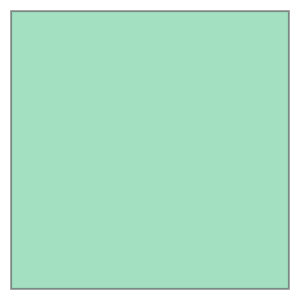

In [4]:
# add buffer value to cover whole area

buffer = 12500 * 3

p1 = (easting+buffer, northing+buffer)
p2 = (easting-buffer, northing+buffer)
p3 = (easting-buffer, northing-buffer)
p4 = (easting+buffer, northing-buffer)

import geopandas as gpd
from shapely.geometry import Polygon
polygon_geom = Polygon((p1, p2, p3, p4))
crs = 'EPSG:3577'
polygon = gpd.GeoDataFrame(index=[0], crs=crs, geometry=[polygon_geom])       
polygon.iloc[0].geometry

In [5]:
# Convert it to OpenDataCube friendly data type

gpgon = datacube.utils.geometry.Geometry(polygon.geometry[0], crs=polygon.crs)

### Load the Burn Cube result by Area of Interest Polygon

In [6]:
# load Burn Cube result from ODC

bc_result = dc.load(
        "ga_s2_ard_bc_fyear_3",
        geopolygon=gpgon,
        output_crs="EPSG:3577",
        resolution=(-30, 30),
    )

In [7]:
bc_result

<xarray.Dataset>
Dimensions:          (time: 1, y: 2501, x: 2501)
Coordinates:
  * time             (time) datetime64[ns] 2019-12-30T12:00:00
  * y                (y) float64 -3.887e+06 -3.887e+06 ... -3.962e+06 -3.962e+06
  * x                (x) float64 4.139e+05 4.139e+05 ... 4.889e+05 4.889e+05
    spatial_ref      int32 3577
Data variables:
    wofsstartdate    (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wofssevere       (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wofsseverity     (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wofsmoderate     (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wofsduration     (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wofscorroborate  (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    wofscleaned      (time, y, x) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    count            (time, y, x) int16 37 37 37 37 39 39 ... 27 26 26 26 26 26
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Generate the date list by fire season information

In [8]:
import datetime

start_date_str = "2019-07-01"
end_date_str = "2020-06-30"

# Convert the start and end date strings to datetime objects
start_date = datetime.datetime.strptime(start_date_str, "%Y-%m-%d")
end_date = datetime.datetime.strptime(end_date_str, "%Y-%m-%d")

# Create a list of dates between the start and end dates
date_list = []
current_date = start_date
while current_date <= end_date:
    date_list.append(current_date)
    # because of LS and S2 data limiation, no need to generate the day by day result
    current_date += datetime.timedelta(days=7)

# Convert the list of dates to string format
date_list_str = [date.strftime("%Y-%m-%d") for date in date_list]

### Covert the Burn Cube startdate variable to user friendly date type

In [9]:
bc_result["wofsstartdate"] = bc_result["wofsstartdate"].astype('datetime64[ns]').dt.strftime('%Y-%m-%d')

### Use fire season date list and Burn Cube raster result to make video

In [10]:
%%time

# JUST USE XARRAY DATASET (Burn Cube result in raster format) TO DISPLAY

# display the Burn Cube result to debug
#def display_burnt_pixel(bc_result, current_date):
#    burnt_pixels = bc_result["wofssevere"].where(bc_result["wofsstartdate"] <= current_date).where(bc_result["wofssevere"] != 0)
#    burnt_pixels[0].plot.imshow(robust=True,cmap='Reds')

def find_burnt_pixel(bc_result, current_date):
    return bc_result["wofssevere"].where(bc_result["wofsstartdate"] <= current_date).where(bc_result["wofssevere"] != 0).drop_vars('time').assign_coords(time=[datetime.datetime.strptime(current_date, "%Y-%m-%d")])

dataset = xr.Dataset()

dataset.update({'burn_cube_display': xr.concat([find_burnt_pixel(bc_result, data_str) for data_str in date_list_str], dim='time')})

xr_animation(
    ds=dataset,
    bands=["burn_cube_display"],
    output_path="demo_bc_without_gdf.gif",
    interval=100,
    imshow_kwargs={"cmap":'Reds'},
    width_pixels=800,
    show_date="%d %b %Y",
    show_colorbar=False,
    annotation_kwargs={"fontsize": 60},
)

# Plot animation
plt.close()

Image(url='demo_bc_without_gdf.gif')  

Exporting animation to demo_bc_without_gdf.gif


  0%|          | 0/53 (0.0 seconds remaining at ? frames/s)

CPU times: user 26 s, sys: 3.12 s, total: 29.1 s
Wall time: 29.1 s


### Burn Cube result Vectorization as GeoPandas

In [11]:
# USE XARRAY DATASET + GEOPANDAS (Burn Cube result in vector format) TO DISPLAY

def find_burnt_as_polygon(bc_result, current_date):
    dataset_transform = bc_result.affine
    burnt_pixel = bc_result["wofssevere"].astype('float32').where(bc_result["wofsstartdate"] <= current_date).where(bc_result["wofssevere"].astype('float32') != 0).drop_vars('time').assign_coords(time=[datetime.datetime.strptime(current_date, "%Y-%m-%d")])
    vector = rasterio.features.shapes(burnt_pixel, mask=burnt_pixel == 1, transform = dataset_transform)
    
    # Extract the polygon coordinates from the list and convert to polygon shapes
    polygons = [shape(polygon) for polygon, _ in vector]
    
    if len(polygons) != 1:
        return MultiPolygon(polygons)
    else:
        return polygons

In [12]:
%%time

# Create a geopandas dataframe populated with the polygon shapes
bc_result_as_gdf = gpd.GeoDataFrame(data={'start_time': date_list_str, 'end_time': date_list_str, 'color': ['red'] * len(date_list_str)},
                                    geometry=[find_burnt_as_polygon(bc_result, current_date) for current_date in tqdm(date_list_str)],
                                    crs=bc_result.crs,)

#save output as GeoJSON as backup
bc_result_as_gdf.to_file(f"bc_{start_date_str}_{end_date_str}.json", driver="GeoJSON")  

# Load the GeoJSON file into a GeoPandas DataFrame
#data_gdf = gpd.read_file(geojson_file_name)


100%|██████████| 53/53 [00:34<00:00,  1.54it/s]


CPU times: user 1min 14s, sys: 660 ms, total: 1min 15s
Wall time: 1min 15s


In [24]:
bc_result_as_gdf.head()

,start_time,end_time,color,geometry
0,2019-07-01,2019-07-01,red,MULTIPOLYGON EMPTY
1,2019-07-08,2019-07-08,red,MULTIPOLYGON EMPTY
2,2019-07-15,2019-07-15,red,"MULTIPOLYGON (((458040.000 -3913500.000, 45804..."
3,2019-07-22,2019-07-22,red,"MULTIPOLYGON (((458040.000 -3913500.000, 45804..."
4,2019-07-29,2019-07-29,red,"MULTIPOLYGON (((448380.000 -3909810.000, 44838..."


### Load the GeoMED data as basemap

In [14]:
gm_ds = dc.load(
        "ga_ls8c_nbart_gm_cyear_3",
        geopolygon=gpgon,
        output_crs="EPSG:3577",
        resolution=(-30, 30),
        time=("2018"), # before fire
    )

In [15]:
gm_ds

<xarray.Dataset>
Dimensions:      (time: 1, y: 2501, x: 2501)
Coordinates:
  * time         (time) datetime64[ns] 2018-07-02T11:59:59.999999
  * y            (y) float64 -3.887e+06 -3.887e+06 ... -3.962e+06 -3.962e+06
  * x            (x) float64 4.139e+05 4.139e+05 ... 4.889e+05 4.889e+05
    spatial_ref  int32 3577
Data variables:
    blue         (time, y, x) int16 302 300 303 302 308 ... 378 378 384 378 388
    green        (time, y, x) int16 168 166 173 172 180 ... 250 257 263 266 266
    red          (time, y, x) int16 116 113 124 125 129 ... 195 195 205 202 206
    nir          (time, y, x) int16 102 99 111 116 120 ... 176 180 185 183 188
    swir1        (time, y, x) int16 85 83 96 103 116 122 ... 149 156 160 164 169
    swir2        (time, y, x) int16 82 80 90 96 107 111 ... 132 138 141 142 150
    sdev         (time, y, x) float32 0.03625 0.03674 ... 0.007728 0.007057
    edev         (time, y, x) float32 166.8 172.6 190.5 ... 217.8 255.5 200.7
    bcdev        (time, y, x) float32 0.2462 0.2768 0.2809 ... 0.1508 0.1325
    count        (time, y, x) int16 22 22 23 21 20 21 22 22 ... 9 9 9 9 9 9 9 9
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

### Modify the GeoMED time by fire season date list

In [16]:
# get the first timestampe data
da_data = gm_ds.isel(time=0).drop_vars('time').to_array()

In [17]:
basemap_da_list = []

for current_date in tqdm(date_list_str):
    da_data = gm_ds.isel(time=0).drop_vars('time').assign_coords(time=[datetime.datetime.strptime(current_date, "%Y-%m-%d")])
    basemap_da_list.append(da_data)

100%|██████████| 53/53 [00:00<00:00, 656.58it/s]


In [18]:
basemap_dataset = xr.Dataset()

basemap_dataset = xr.concat(basemap_da_list, dim='time')

In [19]:
basemap_dataset

<xarray.Dataset>
Dimensions:      (y: 2501, x: 2501, time: 53)
Coordinates:
  * y            (y) float64 -3.887e+06 -3.887e+06 ... -3.962e+06 -3.962e+06
  * x            (x) float64 4.139e+05 4.139e+05 ... 4.889e+05 4.889e+05
    spatial_ref  int32 3577
  * time         (time) datetime64[ns] 2019-07-01 2019-07-08 ... 2020-06-29
Data variables:
    blue         (time, y, x) int16 302 300 303 302 308 ... 378 378 384 378 388
    green        (time, y, x) int16 168 166 173 172 180 ... 250 257 263 266 266
    red          (time, y, x) int16 116 113 124 125 129 ... 195 195 205 202 206
    nir          (time, y, x) int16 102 99 111 116 120 ... 176 180 185 183 188
    swir1        (time, y, x) int16 85 83 96 103 116 122 ... 149 156 160 164 169
    swir2        (time, y, x) int16 82 80 90 96 107 111 ... 132 138 141 142 150
    sdev         (time, y, x) float32 0.03625 0.03674 ... 0.007728 0.007057
    edev         (time, y, x) float32 166.8 172.6 190.5 ... 217.8 255.5 200.7
    bcdev        (time, y, x) float32 0.2462 0.2768 0.2809 ... 0.1508 0.1325
    count        (time, y, x) int16 22 22 23 21 20 21 22 22 ... 9 9 9 9 9 9 9 9
Attributes:
    crs:           EPSG:3577
    grid_mapping:  spatial_ref

In [20]:
# release the temp basemap data collection to save Memory
del basemap_da_list

### Use fire season date list and Burn Cube vectorization result to make video

In [21]:
%%time

xr_animation(
    ds=basemap_dataset,
    bands=['red', 'green', 'blue'],
    output_path="demo_bc_with_gdf.gif",
    interval=100,
    imshow_kwargs={"cmap":'Reds'},
    show_gdf=bc_result_as_gdf,
    width_pixels=800,
    show_date="%d %b %Y",
    show_colorbar=False,
    annotation_kwargs={"fontsize": 60},
    #limit=10,
)

# Plot animation
plt.close()

Exporting animation to demo_bc_with_gdf.gif


  0%|          | 0/53 (0.0 seconds remaining at ? frames/s)

CPU times: user 2min 40s, sys: 19.6 s, total: 2min 59s
Wall time: 2min 59s


In [22]:
Image(url='demo_bc_with_gdf.gif')  

---

## Additional information

**License:** The code in this notebook is licensed under the [Apache License, Version 2.0](https://www.apache.org/licenses/LICENSE-2.0). 
Digital Earth Australia data is licensed under the [Creative Commons by Attribution 4.0](https://creativecommons.org/licenses/by/4.0/) license.

**Contact:** If you need assistance, please post a question on the [Open Data Cube Slack channel](http://slack.opendatacube.org/) or on the [GIS Stack Exchange](https://gis.stackexchange.com/questions/ask?tags=open-data-cube) using the `open-data-cube` tag (you can view previously asked questions [here](https://gis.stackexchange.com/questions/tagged/open-data-cube)).
If you would like to report an issue with this notebook, you can file one on [Github](https://github.com/GeoscienceAustralia/dea-notebooks).

**Last modified:** August 2022

**Compatible datacube version:** 

In [23]:
print(datacube.__version__)

1.8.13
